<h5> Attention Mechanism Enabled Clustering using self trained word vectors </h5>

In [1]:
# IMPORTS BEGIN
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.utils import resample 
from gensim.models import Word2Vec
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from nltk import tokenize
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import math
import numpy as np
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# IMPORTS END

Using TensorFlow backend.
/home/sdin-swt-far-54/miniconda3/envs/taufiq/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sdin-swt-far-54/miniconda3/envs/taufiq/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sdin-swt-far-54/miniconda3/envs/taufiq/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
# GLOBALS BEGIN
maxlen=100
max_sentences=15
max_words=20000
embedding_dim=100
reviews=[]
labels=[]
texts=[]
embeddings_index={}
# GLOBALS END

Class Defining Custom Attention Layer

In [3]:
class Attention(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(Attention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

Data Reading and Analysis

In [4]:
input_data1 = pd.read_csv('/mnt/SWTM_WORK/FAR_ML_CSS/FA_Predictions/ML_Library/Logs/CTUA/drugscomTrain_raw.tsv', sep='\t')
input_data2 = pd.read_csv('/mnt/SWTM_WORK/FAR_ML_CSS/FA_Predictions/ML_Library/Logs/CTUA/drugscomTest_raw.tsv', sep='\t')
input_data = pd.concat([input_data1, input_data2], ignore_index=True)

In [5]:
input_data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
215058,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
215060,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
215061,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [6]:
input_data.shape

(215063, 7)

Getting count of conditions with reviews greater than equal to 10

In [7]:
x = list(input_data.groupby('condition').count()['review']>9)

In [8]:
count = 0
for z in x:
    if z==True:
        count+=1
print(count)

480


Getting count of drugName with reviews greater than equal to 10

In [9]:
x = list(input_data.groupby('drugName').count()['review']>9)

In [10]:
count = 0
for z in x:
    if z==True:
        count+=1
print(count)

1548


Keep condition which have greater than equal to 10 instances
and have max 20 sample of each

In [11]:
def limit_count_per_column(df, column, low=10, high=20):
    in_limits_df =  df.groupby(column).filter(lambda x: high>=len(x)>=low)
    gt_limit_columns = list(df.groupby(column).filter(lambda x: len(x)>high)[column].unique())
    for column_val in gt_limit_columns:
        in_limits_df = pd.concat([in_limits_df,resample(df[df[column]==column_val]
                                                      ,replace=False,n_samples=20,random_state=100)])
    in_limits_df = in_limits_df.reset_index(drop=True)
    return in_limits_df

In [12]:
input_data = limit_count_per_column(input_data, 'condition')

In [13]:
input_data.shape

(8920, 7)

In [14]:
input_data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,34093,Zoledronic acid,Osteolytic Bone Metastases of Solid Tumors,"""I dreaded the side-effects and had NONE. I h...",10.0,"January 25, 2012",31
1,97654,Methimazole,Hyperthyroidism,"""My 6yr old daughter and I have been dealing w...",4.0,"July 11, 2016",3
2,184954,Trolamine salicylate,Bursitis,"""Did help relieve some of the pain temporarily...",7.0,"April 19, 2009",25
3,196987,Paroxetine,Trichotillomania,"""I have OCD, anxiety, and ADHD. I also pick my...",10.0,"April 26, 2016",15
4,35476,Phenol,Sore Throat,"""I will personally attest to this,,,\r\n33 yea...",6.0,"November 5, 2016",7
...,...,...,...,...,...,...,...
8915,22696,Midodrine,Postural Orthostatic Tachycardia Syndrome,"""Didn&#039;t seem to lower my heart rate very ...",3.0,"October 1, 2010",34
8916,46963,Fludrocortisone,Postural Orthostatic Tachycardia Syndrome,"""I have taken this medicine along with Toprol-...",10.0,"August 10, 2010",14
8917,41794,Clonidine,Postural Orthostatic Tachycardia Syndrome,"""Very useful for helping to level out the surg...",9.0,"May 18, 2013",23
8918,163400,Methylphenidate,Postural Orthostatic Tachycardia Syndrome,"""Two months ago, I was unable to work or to dr...",8.0,"January 16, 2017",5


Cluster Train split using Stratification

In [15]:
y = list(input_data['condition'])

In [16]:
def get_train_and_cluster_data(df, y, stratify_column='condition', cluster_ratio=1/5):    
    x_train, x_cluster, y_train, y_cluster = train_test_split(df, y, stratify = df[stratify_column], 
                                                              test_size = cluster_ratio, random_state=42)
    x_train = x_train.reset_index(drop=True)
    x_cluster = x_cluster.reset_index(drop=True)
    return x_train, x_cluster, y_train, y_cluster

In [17]:
x_train, x_cluster, y_train, y_cluster = get_train_and_cluster_data(input_data, y)

In [18]:
x_train.shape, x_cluster.shape

((7136, 7), (1784, 7))

Cleaning and pre processing, using review as input and condition as output

In [19]:
len(set(y_train))

480

In [20]:
len(set(y_cluster))

480

In [21]:
def clean_str(string):
    string = re.sub(r"\\","",string)
    string = re.sub(r"\'","",string)
    string = re.sub(r"\"","",string)
    return string.strip().lower()

In [22]:
for idx in range(x_train.review.shape[0]):
    text = x_train.review[idx][1:-1]
    text = clean_str(text)
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(x_train.condition[idx])

In [23]:
corpus_for_gensim = [x.split() for x in texts]

In [24]:
corpus_for_gensim

[['paxil',
  'was',
  'a',
  'miracle',
  'drug',
  'for',
  'me',
  'in',
  'that',
  'it',
  'completely',
  'got',
  'rid',
  'of',
  'my',
  'anxiety',
  'and',
  'depression.',
  'the',
  'feeling',
  'of',
  'dread',
  'i&#039;d',
  'been',
  'carrying',
  'around',
  'in',
  'the',
  'pit',
  'of',
  'my',
  'stomach',
  'for',
  'years',
  'was',
  'finally',
  'gone!',
  'however,',
  'it',
  'caused',
  'a',
  '50',
  'pound',
  'weight',
  'gain',
  'and',
  'as',
  'a',
  'result',
  'edema',
  'and',
  'other',
  'issues.',
  'i&#039;m',
  'now',
  'on',
  'wellbutrin',
  'xl',
  'and',
  'slowly',
  'starting',
  'to',
  'lose',
  'the',
  'weight.'],
 ['i',
  'have',
  'used',
  'this',
  'medicine.',
  'for',
  'a',
  'stap',
  'bacterial',
  'infection.',
  'normally',
  '9',
  'years',
  'ago',
  'it',
  'would',
  'work',
  'rapidly',
  'and',
  'in',
  '10',
  'days',
  'it',
  'would',
  'be',
  'completely',
  'gone.',
  'but',
  'it',
  'has',
  'come',
  'back',

In [25]:
w2v = Word2Vec(sentences=corpus_for_gensim, size=100, window=5, min_count=1, workers=4)

In [26]:
w2v.wv['good']

array([-1.4845725 , -0.10059901, -1.8875074 ,  0.6246988 ,  0.23301521,
        0.0090217 , -0.07164727, -0.4608572 ,  0.912565  ,  0.4252984 ,
        1.3932613 ,  0.30222544,  0.7690165 , -0.8592755 ,  0.03551764,
        0.09720294, -1.5830323 , -0.02754737,  0.04044269,  0.68078285,
        0.8841589 , -1.8949555 , -1.0994234 ,  1.2310383 ,  0.50806904,
       -0.64629436,  0.72765756,  0.42037246,  0.09341489, -0.06754547,
        0.2809154 ,  0.29104716, -0.34726295, -0.15651368,  0.5805608 ,
        0.41544873,  0.71021926,  0.85865504,  0.34785622,  0.36415407,
       -0.05326447, -0.20882256, -0.7692089 , -0.11951446,  1.1135666 ,
        0.1384753 , -0.62314373, -0.49882615,  0.951284  ,  0.6688652 ,
       -0.11697861,  0.3576232 ,  0.5387317 ,  0.34315145,  0.13697743,
        0.72928   ,  0.3719517 , -0.05290043, -0.7776025 ,  0.13680325,
       -0.18945333, -0.83962494, -0.55704784, -0.8119437 , -0.3824067 ,
        0.8408806 ,  0.04605205,  0.78790796, -0.64374065, -0.71

In [27]:
len(labels)

7136

In [28]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [29]:
train_data = np.zeros((len(texts), max_sentences, maxlen), dtype='int32')

In [30]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k < maxlen and tokenizer.word_index[word] < max_words:
                    train_data[i, j, k] = tokenizer.word_index[word]
                    k=k+1

In [31]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 14864 unique tokens.


In [32]:
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

In [33]:
labels

array([ 17,  68, 238, ..., 231, 402, 346])

In [34]:
print('unique conditions:', len(set(labels)))

unique conditions: 480


In [35]:
print('Shape of reviews (data) tensor:', train_data.shape)
print('Shape of condition (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (7136, 15, 100)
Shape of condition (label) tensor: (7136,)


In [36]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
labels = labels[indices]

Using self trained embeddings

In [37]:
i=0
for word,i in w2v.wv.vocab.items():
    embedding_vectorc = w2v.wv[word]
    if embedding_vectorc is not None:
        embeddings_index[word]=i.index 
        
# f = open(os.path.join('/mnt/SWTM_WORK/FAR_ML_CSS/FA_Predictions/ML_Library/Logs/CTUA/', 'glove.6B.100d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word]=coefs
# f.close()

In [38]:
print('Total %s word vectors. in self trained word embeddings' % len(embeddings_index))

Total 28680 word vectors. in self trained word embeddings


In [39]:
embedding_matrix = np.random.random((len(word_index)+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeroes
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_layer = Embedding(len(word_index)+1, embedding_dim, weights=[embedding_matrix],
                           input_length=maxlen, trainable=True,mask_zero=True)

In [41]:
labels = to_categorical(labels)

Attention training and final clustering

In [42]:
x_train = train_data
y_train = labels

In [43]:
sentence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = Attention(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [44]:
review_input = Input(shape=(max_sentences, maxlen), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
attn_sentence = Attention(100)(lstm_sentence)
preds = Dense(y_train.shape[1], activation='softmax')(attn_sentence)
model = Model(review_input, preds)

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [46]:
print("model fitting - HAN")
model.fit(x_train, y_train, epochs= 100, batch_size=100)

model fitting - HAN
Epoch 1/100
7136/7136 [==============================] - 12s 2ms/step - loss: 6.1763 - acc: 9.8094e-04
Epoch 2/100
7136/7136 [==============================] - 10s 1ms/step - loss: 6.1499 - acc: 0.0027
Epoch 3/100
7136/7136 [==============================] - 10s 1ms/step - loss: 6.1021 - acc: 0.0053
Epoch 4/100
7136/7136 [==============================] - 10s 1ms/step - loss: 6.0535 - acc: 0.0059
Epoch 5/100
7136/7136 [==============================] - 10s 1ms/step - loss: 6.0085 - acc: 0.0066
Epoch 6/100
7136/7136 [==============================] - 10s 1ms/step - loss: 5.9537 - acc: 0.0095
Epoch 7/100
7136/7136 [==============================] - 10s 1ms/step - loss: 5.8774 - acc: 0.0115
Epoch 8/100
7136/7136 [==============================] - 10s 1ms/step - loss: 5.7840 - acc: 0.0150
Epoch 9/100
7136/7136 [==============================] - 10s 1ms/step - loss: 5.6652 - acc: 0.0238
Epoch 10/100
7136/7136 [==============================] - 10s 1ms/step - loss: 5.5321

7136/7136 [==============================] - 10s 1ms/step - loss: 1.1048 - acc: 0.7801
Epoch 83/100
7136/7136 [==============================] - 10s 1ms/step - loss: 1.1079 - acc: 0.7807
Epoch 84/100
7136/7136 [==============================] - 10s 1ms/step - loss: 1.0404 - acc: 0.7967
Epoch 85/100
7136/7136 [==============================] - 10s 1ms/step - loss: 1.0086 - acc: 0.7992
Epoch 86/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.9702 - acc: 0.8026
Epoch 87/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.9623 - acc: 0.8052
Epoch 88/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.9457 - acc: 0.8065
Epoch 89/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.9125 - acc: 0.8117
Epoch 90/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.8915 - acc: 0.8159
Epoch 91/100
7136/7136 [==============================] - 10s 1ms/step - loss: 0.8749 - acc: 0.8171
Epoch 92/100


In [47]:
model_vec = Model(inputs=review_input,outputs=attn_sentence)
model_vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
reviews = []
labels = []
texts = []

In [49]:
for idx in range(x_cluster.review.shape[0]):
    text = x_cluster.review[idx][1:-1]
    text = clean_str(text)
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(x_cluster.condition[idx])

In [50]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [51]:
cluster_data = np.zeros((len(texts), max_sentences, maxlen), dtype='int32')

In [52]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k < maxlen and tokenizer.word_index[word] < max_words:
                    cluster_data[i, j, k] = tokenizer.word_index[word]
                    k=k+1

In [53]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 8391 unique tokens.


In [54]:
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

In [55]:
indices = np.arange(cluster_data.shape[0])
np.random.shuffle(indices)
cluster_data = cluster_data[indices]
labels = labels[indices]

In [56]:
x_clustering_vec = model_vec.predict(cluster_data)

In [57]:
x_clustering_vec[0]

array([-9.99836922e-01, -9.99762595e-01,  5.94655573e-01,  9.99782026e-01,
        1.13535643e-01,  9.52550709e-01, -9.86966133e-01,  9.99986112e-01,
        1.45197855e-11,  7.09942400e-01, -9.99999642e-01,  9.99996305e-01,
        9.89805281e-01,  9.99950051e-01, -8.54617059e-01, -7.94249594e-01,
       -9.89243746e-01, -7.35132277e-01, -5.07345021e-01,  9.53211546e-01,
        6.37141526e-01, -5.52386343e-01,  1.73864976e-01, -8.30393970e-01,
       -9.89542425e-01, -1.35609075e-01,  9.79180038e-01, -8.78363788e-01,
        6.51066959e-01,  9.99582648e-01, -1.11129795e-11,  1.89631279e-11,
        9.17367041e-01,  5.58293949e-12, -9.13182735e-01, -9.46062446e-01,
        1.72732845e-01, -3.49106938e-02,  1.91295261e-11,  7.65991092e-01,
       -9.99982059e-01, -5.29468060e-03, -9.07157898e-01, -9.85490024e-01,
       -3.34526300e-02,  4.41793680e-01,  2.18254253e-01,  3.18795728e-12,
        2.81906039e-01,  9.89383399e-01,  8.54569435e-01,  5.01162931e-03,
        7.44369447e-01, -

Pre Clustering Analysis

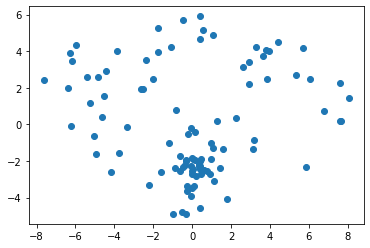

In [58]:

pca = PCA(n_components=2)
reduced = pca.fit_transform(x_clustering_vec[:100])

t = reduced.transpose()

plt.scatter(t[0], t[1])
plt.show()

Clustering Models

In [59]:
def k_means(data, n_clusters=480, max_iter=1000):
    model = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(data)
    return model
def agglomerative_fn(data, n_clusters=480):
    model = AgglomerativeClustering(n_clusters = n_clusters).fit(data)
    return model
def dbscan_fn(data, eps=0.45, min_samples=4):
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    return model
def mean_shift_fn(data, bandwidth=0.85):
    model = MeanShift(bandwidth=bandwidth).fit(data)
    return model
def birch_fn(data, n_clusters=480):
    model = Birch(n_clusters=n_clusters).fit(data)
    return model
def affinity_propagation_fn(data, damping=0.6, max_iter=1000):
    model = AffinityPropagation(damping=damping, max_iter=max_iter).fit(data)
    return model
def mini_batch_kmeans_fn(data, n_clusters=480, max_iter=1000):
    model = MiniBatchKMeans(n_clusters=n_clusters, max_iter=max_iter, batch_size=20).fit(data)
    return model

In [60]:
def build_model(clustering_model, data, labels):
    
    model = clustering_model(data)

    print('homo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print(50 * '-')
    
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          %(metrics.homogeneity_score(labels, model.labels_),
            metrics.completeness_score(labels, model.labels_),
            metrics.v_measure_score(labels, model.labels_),
            metrics.adjusted_rand_score(labels, model.labels_),
            metrics.adjusted_mutual_info_score(labels,  model.labels_),
            metrics.silhouette_score(data, model.labels_)))

In [61]:
build_model(k_means, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.743	0.780	0.761	0.010	0.018	0.152


In [62]:
build_model(agglomerative_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.753	0.782	0.767	0.009	0.017	0.177


In [63]:
build_model(dbscan_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.018	0.618	0.036	0.000	0.000	-0.086


In [64]:
build_model(mean_shift_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.973	0.822	0.891	0.018	0.020	0.094


In [65]:
build_model(birch_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.748	0.781	0.764	0.009	0.017	0.167


In [66]:
build_model(affinity_propagation_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.596	0.741	0.661	0.005	0.011	0.095


In [67]:
build_model(mini_batch_kmeans_fn, x_clustering_vec, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.708	0.772	0.739	0.007	0.016	0.099
